In [2]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [5]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 1: Data Preprocessing (Normalization)

In [47]:
# color scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

udf = pd.read_csv('uae.csv')

In [48]:
print(udf.shape)
print(udf["FID"].min(), udf["FID"].max())

# Note that some ids are missing in the data

(294, 2158)
1 325


# Step 3:  Train-Test Split  and its Goodness

In [ ]:
def bin_error(X,y,tst_siz):
    ymin = y.min()
    ymax = y.max()
    trn_siz = 1-tst_siz
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= tst_siz, random_state=0)
    rand_st = 0
    bin_train = np.histogram(y_train, bins = 8, range = (ymin,ymax), density=False)
    bin_test = np.histogram(y_test, bins = 8, range = (ymin,ymax), density=False)
    error = abs((bin_train[0])/trn_siz - (bin_test[0])/tst_siz)
    cum_error = error.sum()
    min_err= cum_error
    
    for i in np.arange(1,40,1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= tst_siz, random_state=i)
        bin_train = np.histogram(y_train, bins = 8, range = (ymin,ymax), density=False)
        bin_test = np.histogram(y_test, bins = 8, range = (ymin,ymax), density=False)
        error = abs((bin_train[0])/trn_siz - (bin_test[0])/tst_siz)
        cum_error = error.sum()
        if cum_error < min_err:
            min_err = cum_error
            rand_st = i
            #print(i)

    return (min_err, rand_st)
    
 
min_err, rand_st = bin_error(X, yN, tst_siz)
print ('Nitrogen: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_st)
randN = rand_st

min_err, rand_st = bin_error(X, yP, tst_siz)
print ('Phosphorus: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_st)
randP = rand_st

min_err, rand_st = bin_error(X, yK, tst_siz)
print ('Potassium: ')
print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_st)
randK = rand_st


In [13]:
y_silt = udf.loc[:, 'silt']
y_sand = udf.loc[:, 'sand']
y_clay = udf.loc[:, 'clay']
y_toc = udf.loc[:, 'TOC']

In [16]:


# tst_siz = 0.3
# X = udf.iloc[:, 7:2158].copy()

# rand_sand, min_err = best_split(X, y_sand, tst_siz)
# print ('Sand: ')
# print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_sand)

# rand_silt, min_err = best_split(X, y_silt, tst_siz)
# print ('Silt: ')
# print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_silt)

# rand_clay, min_err = best_split(X, y_clay, tst_siz)
# print ('Clay: ')
# print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_clay)

# rand_toc, min_err = best_split(X, y_toc, tst_siz)
# print ('TOC: ')
# print ('For test size =', tst_siz, '\t min bin error:', min_err, '\t found at randome state =', rand_toc)

Sand: 
For test size = 0.3 	 min bin error: 13.33333333333334 	 found at randome state = 3
Silt: 
For test size = 0.3 	 min bin error: 24.76190476190476 	 found at randome state = 4
Clay: 
For test size = 0.3 	 min bin error: 30.476190476190474 	 found at randome state = 8
TOC: 
For test size = 0.3 	 min bin error: 41.9047619047619 	 found at randome state = 17


##  Optimal Train-Test Split

In [17]:
# Splitting the sample into train-test samples using obtained optimal parameters
XSand_train, XSand_test, ySand_train, ySand_test = train_test_split(X, y_sand, test_size= tst_siz, random_state=rand_sand)

XSilt_train, XSilt_test, ySilt_train, ySilt_test = train_test_split(X, y_silt, test_size= tst_siz, random_state=rand_silt)

XClay_train, XClay_test, yClay_train, yClay_test = train_test_split(X, y_clay, test_size= tst_siz, random_state=rand_clay)

XTOC_train, XTOC_test, yTOC_train, yTOC_test = train_test_split(X, y_toc, test_size= tst_siz, random_state=rand_toc)
print ('\n \n Optimal Train-Test Split Done for y_sand y_silt y_clay y_toc')


 
 Optimal Train-Test Split Done for y_sand y_silt y_clay y_toc


Text(0.5, 0.95, 'Train Test Distribution of Data')

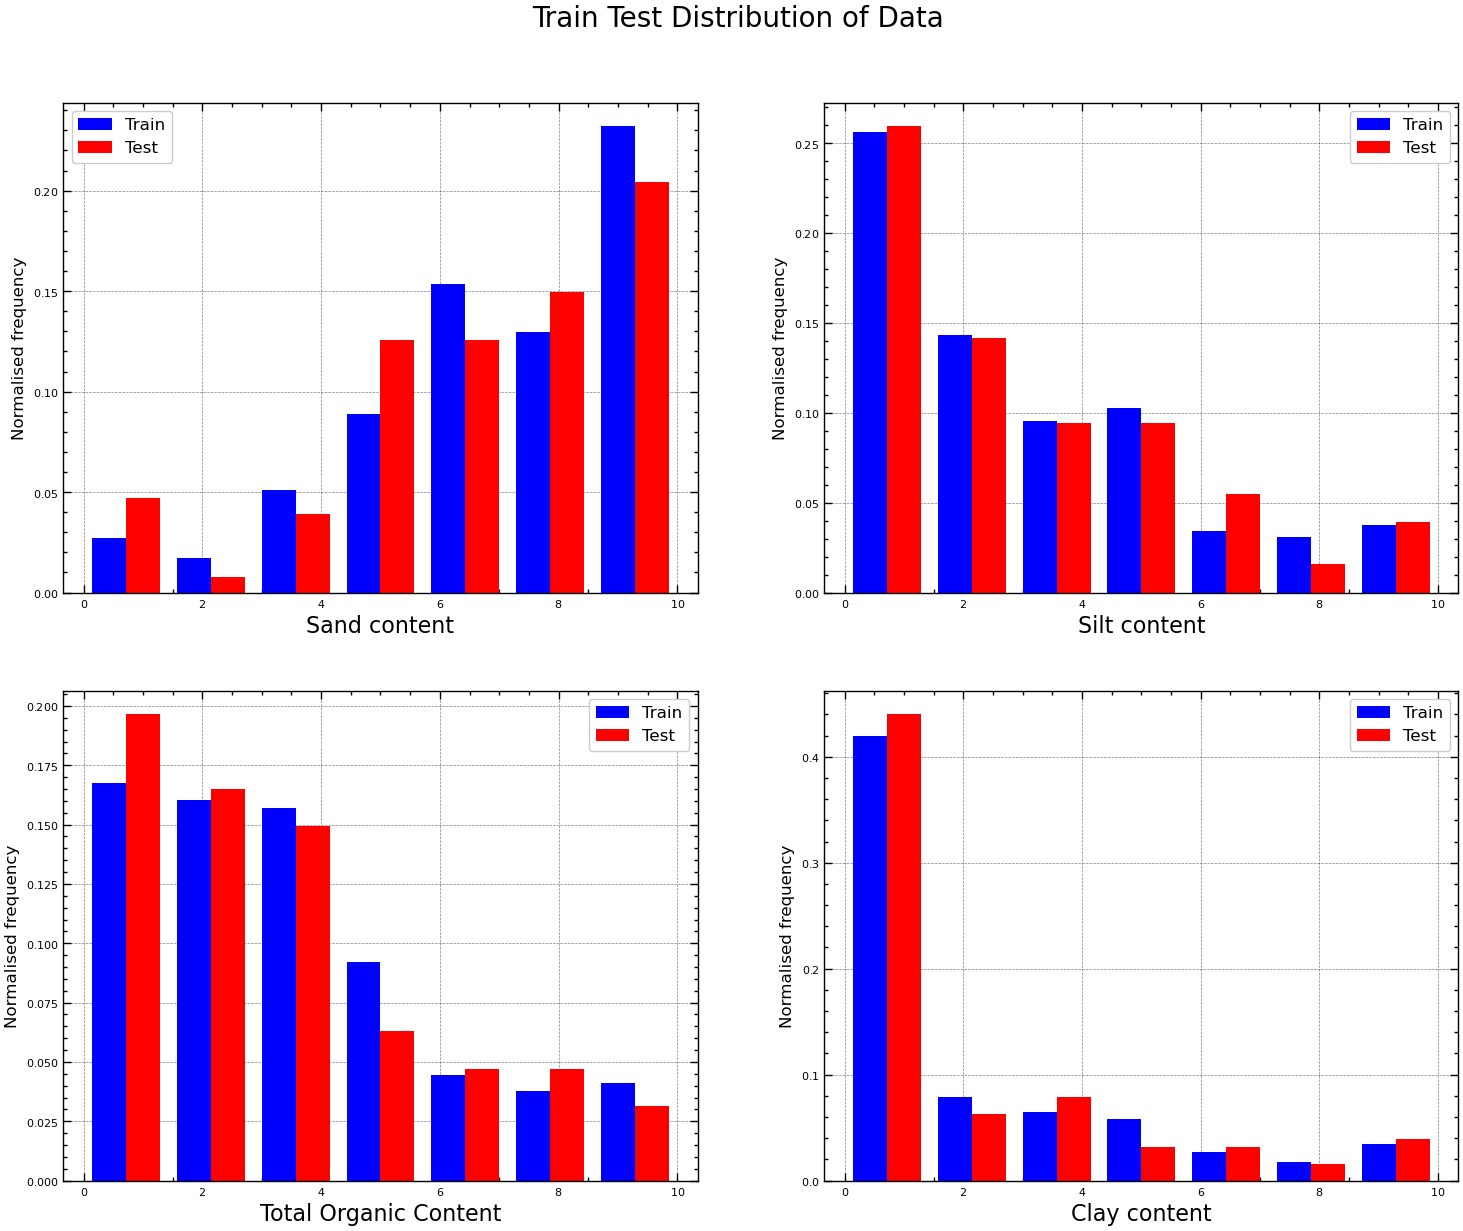

In [18]:
# ## Plotting the Distribution of Train and Test Output Data 
# ## Plotting the Distribution of Train and Test Output Data 
plt.style.use(['science','notebook','grid'])

fig, ax = plt.subplots(2,2, figsize=(18,14))

minSand = np.min(y_sand)
maxSand = np.max(y_sand)

binsSand = np.linspace(minSand, maxSand, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[0][0].hist([ySand_train, ySand_test], binsSand , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[0][0].legend(loc='upper left', fontsize =12)
ax[0][0].set_xlabel('Sand content',fontsize =16)
ax[0][0].set_ylabel('Normalised frequency',fontsize =12)
ax[0][0].tick_params(axis='both', labelsize=8)

minSilt = np.min(y_silt)
maxSilt = np.max(y_silt)

binsSilt = np.linspace(minSilt, maxSilt, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[0][1].hist([ySilt_train, ySilt_test], binsSilt , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[0][1].legend(loc='upper right', fontsize =12)
ax[0][1].set_xlabel('Silt content',fontsize =16)
ax[0][1].set_ylabel('Normalised frequency',fontsize =12)
ax[0][1].tick_params(axis='both', labelsize=8)

minClay = np.min(y_clay)
maxClay = np.max(y_clay)

binsClay = np.linspace(minClay, maxClay, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[1][1].hist([yClay_train, yClay_test], binsClay , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[1][1].legend(loc='upper right', fontsize =12)
ax[1][1].set_xlabel('Clay content',fontsize =16)
ax[1][1].set_ylabel('Normalised frequency',fontsize =12)
ax[1][1].tick_params(axis='both', labelsize=8)

minTOC = np.min(y_toc)
maxTOC = np.max(y_toc)

binsTOC = np.linspace(minTOC, maxTOC, 8)
# density =True : used to normalise bin heights to make the integral of  histogram 1.
ax[1][0].hist([yTOC_train, yTOC_test], binsTOC , label=['Train', 'Test'], density=True, color = ['blue','red'])
# results in error when yN_train/ yN_test is data frame or ndarray
ax[1][0].legend(loc='upper right', fontsize =12)
ax[1][0].set_xlabel('Total Organic Content',fontsize =16)
ax[1][0].set_ylabel('Normalised frequency',fontsize =12)
ax[1][0].tick_params(axis='both', labelsize=8)

fig.suptitle('Train Test Distribution of Data', x = 0.5 ,y = .95, fontsize = 20)

#plt.show()

# Finding best model Parameters (window, n_components)

In [32]:
from sklearn import linear_model

def best_param_MLR (spectra, target, rand_st, tst_siz, window):
    X= spectra.copy()
    y= target.copy()
     
    iqrpM = np.zeros(shape=(window, window))
    iqrpMtr = np.zeros(shape=(window, window))
    # test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = tst_siz, random_state=rand_st)
    for w in range (0,window):
        X_train_smth = sgsmooth (X_train, w)
        X_test_smth = sgsmooth (X_test, w)
        
        Model = linear_model.LinearRegression()
        Model.fit(X_train_smth, y_train)
        y_pred = Model.predict(X_test_smth)
        yhat_pred = Model.predict(X_train_smth)            
            
        iqrp_test = iqrp(y_pred, y_test)
        iqrp_train = iqrp(yhat_pred, y_train)
            
        iqrpM[w] = iqrp_test
        iqrpMtr[w] = iqrp_train
            
            
        if iqrp_test == iqrpM.max():
            bestw = w
            maxIQRP = iqrp_test
            print('Found new best at w=', w, '>>   IQRP_test =', iqrp_test, '>>   IQRP_train =', iqrp_train)
                
            if iqrp_train == iqrpMtr.max():
                bestwT = w
                maxIQRPT = iqrp_train
            
    print('On Train data best at w=', bestwT, '>IQRP_train =', maxIQRPT)                    
                
    return (bestw, maxIQRP)


In [33]:
spectra = udf.iloc[:, 7:2158].copy()
w1, IQRP1 = best_param_MLR (spectra, y_sand, rand_sand, 0.3, 5)

Found new best at w= 0 >>   IQRP_test = 1.1985435610907298 >>   IQRP_train = 2144435706251.4949
On Train data best at w= 0 >IQRP_train = 2144435706251.4949


In [40]:
spectra = udf.iloc[:, 7:2158].copy()
w2, IQRP2 = best_param_MLR (spectra, y_silt, rand_silt, 0.3, 5)  

Found new best at w= 0 >>   IQRP_test = 1.0294436778566072 >>   IQRP_train = 2659559064002.1294
Found new best at w= 3 >>   IQRP_test = 1.0593473674181728 >>   IQRP_train = 1069497294000.646
Found new best at w= 4 >>   IQRP_test = 1.0612866276334323 >>   IQRP_train = 982880795513.4266
On Train data best at w= 0 >IQRP_train = 2659559064002.1294


In [41]:
spectra = udf.iloc[:, 7:2158].copy()
w3, IQRP3 = best_param_MLR (spectra, y_clay, rand_clay, 0.3, 5)

Found new best at w= 0 >>   IQRP_test = 1.2350434081474826 >>   IQRP_train = 2817180967612.8003
On Train data best at w= 0 >IQRP_train = 2817180967612.8003


In [42]:
spectra = udf.iloc[:, 7:2158].copy()
w4, IQRP4 = best_param_MLR (spectra, y_toc, rand_toc, 0.3, 5)

Found new best at w= 0 >>   IQRP_test = 0.9876182518288584 >>   IQRP_train = 2291973987422.1587
Found new best at w= 1 >>   IQRP_test = 0.9883395290344705 >>   IQRP_train = 1862248881434.2417
On Train data best at w= 0 >IQRP_train = 2291973987422.1587


# Step 4: Training the Model

        - Create a linear regr object
        - Apply fit function (using regr object) on training data
        - Check the weights/parameters generated by fit function 

In [43]:
from sklearn import linear_model

regSand = linear_model.LinearRegression()
regSilt = linear_model.LinearRegression()
regClay = linear_model.LinearRegression()
regTOC = linear_model.LinearRegression()

# train the model using X_train and y_train (identified in previous step)

XSand_train_smth = sgsmooth (XSand_train, w1)       
regSand.fit(XSand_train_smth, ySand_train)

XSilt_train_smth = sgsmooth (XSilt_train, w2)
regSilt.fit(XSilt_train_smth, ySilt_train)

XClay_train_smth = sgsmooth (XClay_train, w3)
regClay.fit(XClay_train_smth, yClay_train)

XTOC_train_smth = sgsmooth (XTOC_train, w4)
regTOC.fit(XTOC_train_smth, yTOC_train)


LinearRegression()

# Step 5: Prediction on Test Data 

In [44]:
# Predition using the trained-Model on the "Test Data"

ySand_pred = regSand.predict(XSand_test_smth)
ySand_pred = np.round(ySand_pred, 2)

ySilt_pred = regSilt.predict(XSilt_test_smth)
ySilt_pred = np.round(ySilt_pred, 2)

yClay_pred = regClay.predict(XClay_test_smth)
yClay_pred = np.round(yClay_pred, 2)

yTOC_pred = regTOC.predict(XTOC_test_smth)
yTOC_pred = np.round(yTOC_pred, 2)


NameError: name 'XSand_test_smth' is not defined

# Step 6: Model Accuracy and Plots

###  Model Accuracy  (Sand)

In [462]:
#  Mean percentage error
#error = np.mean(abs((ySand_pred - ySand_test)/ySand_test))

#  Calculate the rmse for training data
yhatSand_pred = regSand.predict(XSand_train)
mseTrain = mean_squared_error(ySand_train, yhatSand_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(ySand_test, ySand_pred)
rmseTest = np.sqrt(mseTest)

print('Sand Model Accuracy') 
#print('Mean Percentage Error:', error*100)  
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
rmseSand = rmseTest

Sand Model Accuracy
Root Mean Square Error (Training): 0.000
Root Mean Square Error (Testing): 0.847


###  Model Accuracy  (Silt)

In [463]:
#  Mean percentage error

#  Calculate the rmse for training data
yhatSilt_pred = regSilt.predict(XSilt_train)
mseTrain = mean_squared_error(ySilt_train, yhatSilt_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(ySilt_test, ySilt_pred)
rmseTest = np.sqrt(mseTest)

print('Silt Model Accuracy')   
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
rmseSilt = rmseTest

Silt Model Accuracy
Root Mean Square Error (Training): 0.000
Root Mean Square Error (Testing): 1.697


###  Model Accuracy  (Clay)

In [464]:
#  Mean percentage error

#  Calculate the rmse for training data
yhatClay_pred = regClay.predict(XClay_train)
mseTrain = mean_squared_error(yClay_train, yhatClay_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(yClay_test, yClay_pred)
rmseTest = np.sqrt(mseTest)

print('Clay Model Accuracy') 
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
rmseClay = rmseTest

Clay Model Accuracy
Root Mean Square Error (Training): 0.000
Root Mean Square Error (Testing): 2.494


###  Model Accuracy  (TOC)

In [465]:
#  Mean percentage error

#  Calculate the rmse for training data
yhatTOC_pred = regTOC.predict(XTOC_train)
mseTrain = mean_squared_error(yTOC_train, yhatTOC_pred)
rmseTrain = np.sqrt(mseTrain)
#  Calculate the rmse for testing data
mseTest = mean_squared_error(yTOC_test, yTOC_pred)
rmseTest = np.sqrt(mseTest)

print('Total Organic Content Model Accuracy') 
#print('Mean Percentage Error:', error*100)  
print('Root Mean Square Error (Training): %.3f' % rmseTrain)
print('Root Mean Square Error (Testing): %.3f' % rmseTest)
rmseTOC = rmseTest

Total Organic Content Model Accuracy
Root Mean Square Error (Training): 0.000
Root Mean Square Error (Testing): 1.564


In [466]:
# Merging actual and predicted (Test data) in one data frame for plots
ySand_tp = pd.DataFrame({'actual':ySand_test.values, 'predic': ySand_pred})
ySand_sortedA = ySand_tp.sort_values(by =['actual'])
ySand_srtA = ySand_sortedA.reset_index(drop=True)

ySilt_tp = pd.DataFrame({'actual':ySilt_test.values, 'predic': ySilt_pred})
ySilt_sortedA = ySilt_tp.sort_values(by =['actual'])
ySilt_srtA = ySilt_sortedA.reset_index(drop=True)

yClay_tp = pd.DataFrame({'actual':yClay_test.values, 'predic': yClay_pred})
yClay_sortedA = yClay_tp.sort_values(by =['actual'])
yClay_srtA = yClay_sortedA.reset_index(drop=True)

yTOC_tp = pd.DataFrame({'actual':yTOC_test.values, 'predic': yTOC_pred})
yTOC_sortedA = yTOC_tp.sort_values(by =['actual'])
yTOC_srtA = yTOC_sortedA.reset_index(drop=True)

In [468]:
# Plots for Visualising the Model Accuracy
plt.style.use(['science','notebook','grid'])

def plot_pred_acc (target):

    fig, axes = plt.subplots(1,1, figsize=(8,7))

    if target == 'sand':
        ySand_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = balu)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'SAND', fontsize = 20, color = balu)
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSand), fontsize = 16)

    elif target == 'clay':
        yClay_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = mati)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'CLAY', fontsize = 20, color = mati)
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseClay), fontsize = 16)
        
    elif target == 'silt':
        ySilt_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = kado)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'SILT', fontsize = 20, color = kado)
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseSilt), fontsize = 16)

    elif target == 'TOC':
        yTOC_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = 'green')
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'TOC', fontsize = 20, color = 'green')
        plt.text(1, 10.2, 'RMSE ={:.2f}'.format(rmseTOC), fontsize = 16)
        
    else:  
        ySand_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = balu)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(3, 11, 'SAND', fontsize = 20, color = balu)
        yClay_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = mati)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(3, 10, 'CLAY', fontsize = 20, color = mati)
        ySilt_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = kado)
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 11, 'SILT', fontsize = 20, color = kado)
        yTOC_srtA.plot.scatter(ax= axes, x="actual", y="predic", alpha=0.8, color = 'green')
        axes.tick_params(axis='both', labelsize=10)
        plt.text(1, 10, 'TOC', fontsize = 20, color = 'green')

    fig.suptitle('Predictions on "Test" Data', x = 0.5 ,y = .95, fontsize=20)
    plt.xlim([0, 12])
    plt.ylim([0, 12])
    plt.show()

ipywidgets.interact(plot_pred_acc, target = ['sand', 'clay', 'silt', 'TOC', 'All'])


interactive(children=(Dropdown(description='target', options=('sand', 'clay', 'silt', 'TOC', 'All'), value='sa…

<function __main__.plot_pred_acc(target)>